## Time Series Model to predict the storm charactertics(speed, pressure and USA_SSHS values) of future date

X_seq shape: (52441, 10, 3)
X_static shape: (52441, 6)
y shape: (52441, 3)
Epoch 1/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0212 - val_loss: 0.0022
Epoch 2/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 3/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 4/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 11/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 

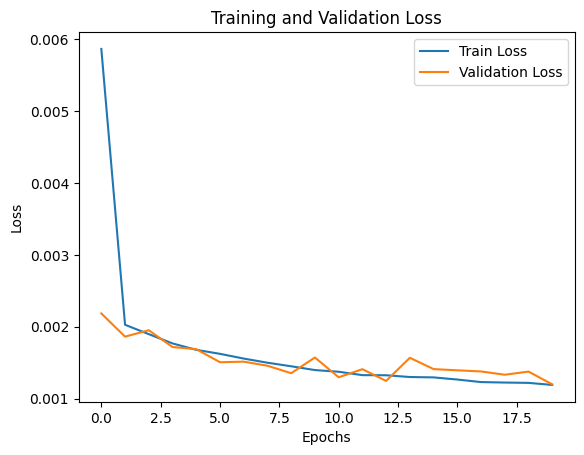

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted Maximum USA_SSHS: 2.834749460220337
Predicted Maximum Storm Speed (WMO_WIND): 0.9176911115646362
Predicted Minimum Pressure (WMO_PRES): 1.0095494985580444


/Users/yashwanthys/miniconda3/envs/ids/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/yashwanthys/miniconda3/envs/ids/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
import matplotlib.pyplot as plt
from datetime import datetime

def preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['ISO_TIME'] = pd.to_datetime(data['ISO_TIME'], errors='coerce')
    data = data.sort_values(by=['SID', 'ISO_TIME'])
    features = ['SID', 'ISO_TIME', 'WMO_WIND', 'WMO_PRES', 'USA_SSHS', 'LAT', 'LON', 'LandAndOceanAverageTemperature']
    data = data[features]
    data['day_of_year'] = data['ISO_TIME'].dt.dayofyear
    data['month'] = data['ISO_TIME'].dt.month
    data['weekday'] = data['ISO_TIME'].dt.weekday
    data = data.replace(' ', np.nan)
    data = data.dropna()
    numeric_columns = ['WMO_WIND', 'WMO_PRES', 'USA_SSHS', 'LAT', 'LON', 'LandAndOceanAverageTemperature',
                       'day_of_year', 'month', 'weekday']
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')
    data = data.dropna()
    return data

def create_sequences_with_static(data, sequence_length):
    grouped = data.groupby('SID')
    X_seq, X_static, y = [], [], []
    for sid, group in grouped:
        group = group.drop(columns=['SID', 'ISO_TIME']).to_numpy()
        if len(group) >= sequence_length:
            for i in range(len(group) - sequence_length + 1):
                X_seq.append(group[i:i + sequence_length, :-6])
                X_static.append(group[i + sequence_length - 1, -6:])
                y.append([
                    group[:, -6].max(),
                    group[:, -5].max(),
                    group[:, -4].min()
                ])
    assert len(X_seq) == len(X_static) == len(y)
    return np.array(X_seq), np.array(X_static), np.array(y)

def build_model(sequence_length, n_features, n_static_features, n_outputs):
    input_seq = Input(shape=(sequence_length, n_features))
    x = LSTM(128, return_sequences=True)(input_seq)
    x = LSTM(128, return_sequences=False)(x)
    input_static = Input(shape=(n_static_features,))
    s = Dense(64, activation='relu')(input_static)
    combined = Concatenate()([x, s])
    combined = Dense(128, activation='relu')(combined)
    combined = Dense(64, activation='relu')(combined)
    outputs = Dense(n_outputs)(combined)
    model = Model(inputs=[input_seq, input_static], outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

file_path = '../data/merged_data.csv'
data = preprocess_data(file_path)

seq_features = ['WMO_WIND', 'WMO_PRES', 'USA_SSHS']
static_features = ['LandAndOceanAverageTemperature', 'LAT', 'LON', 'day_of_year', 'month', 'weekday']

scaler_seq = MinMaxScaler()
scaler_static = MinMaxScaler()
data[seq_features] = scaler_seq.fit_transform(data[seq_features])
data[static_features] = scaler_static.fit_transform(data[static_features])

sequence_length = 10
X_seq, X_static, y = create_sequences_with_static(data, sequence_length)

print(f"X_seq shape: {X_seq.shape}")
print(f"X_static shape: {X_static.shape}")
print(f"y shape: {y.shape}")

X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
    X_seq, X_static, y, test_size=0.2, random_state=42
)

n_features = X_seq.shape[2]
n_static_features = X_static.shape[1]
n_outputs = y.shape[1]
model = build_model(sequence_length, n_features, n_static_features, n_outputs)

history = model.fit(
    [X_seq_train, X_static_train], y_train,
    validation_data=([X_seq_test, X_static_test], y_test),
    epochs=20, batch_size=32, verbose=1
)

loss = model.evaluate([X_seq_test, X_static_test], y_test)
print(f"Test Loss: {loss}")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

new_sequence = np.random.rand(sequence_length, len(seq_features))
future_date = "2024-12-15"
future_date_dt = datetime.strptime(future_date, "%Y-%m-%d")
day_of_year = future_date_dt.timetuple().tm_yday
month = future_date_dt.month
weekday = future_date_dt.weekday()
land_temp = 25.0
lat = -15.5
lon = 150.0
new_static = np.array([[land_temp, lat, lon, day_of_year, month, weekday]])
new_sequence_scaled = scaler_seq.transform(new_sequence)
new_static_scaled = scaler_static.transform(new_static)
predicted_values = model.predict([np.expand_dims(new_sequence_scaled, axis=0), new_static_scaled])
print(f"Predicted Maximum USA_SSHS: {predicted_values[0][0]}")
print(f"Predicted Maximum Storm Speed (WMO_WIND): {predicted_values[0][1]}")
print(f"Predicted Minimum Pressure (WMO_PRES): {predicted_values[0][2]}")


328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012
Test Loss (MSE from the model): 0.0011971298372372985
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Metrics for Max USA_SSHS:
  Mean Absolute Error (MAE): 0.0239
  Mean Squared Error (MSE): 0.0013
  Root Mean Squared Error (RMSE): 0.0363
  R-squared (R²): 0.9534
Metrics for Max WMO_WIND:
  Mean Absolute Error (MAE): 0.0170
  Mean Squared Error (MSE): 0.0006
  Root Mean Squared Error (RMSE): 0.0244
  R-squared (R²): 0.9893
Metrics for Min WMO_PRES:
  Mean Absolute Error (MAE): 0.0227
  Mean Squared Error (MSE): 0.0017
  Root Mean Squared Error (RMSE): 0.0409
  R-squared (R²): 0.9830


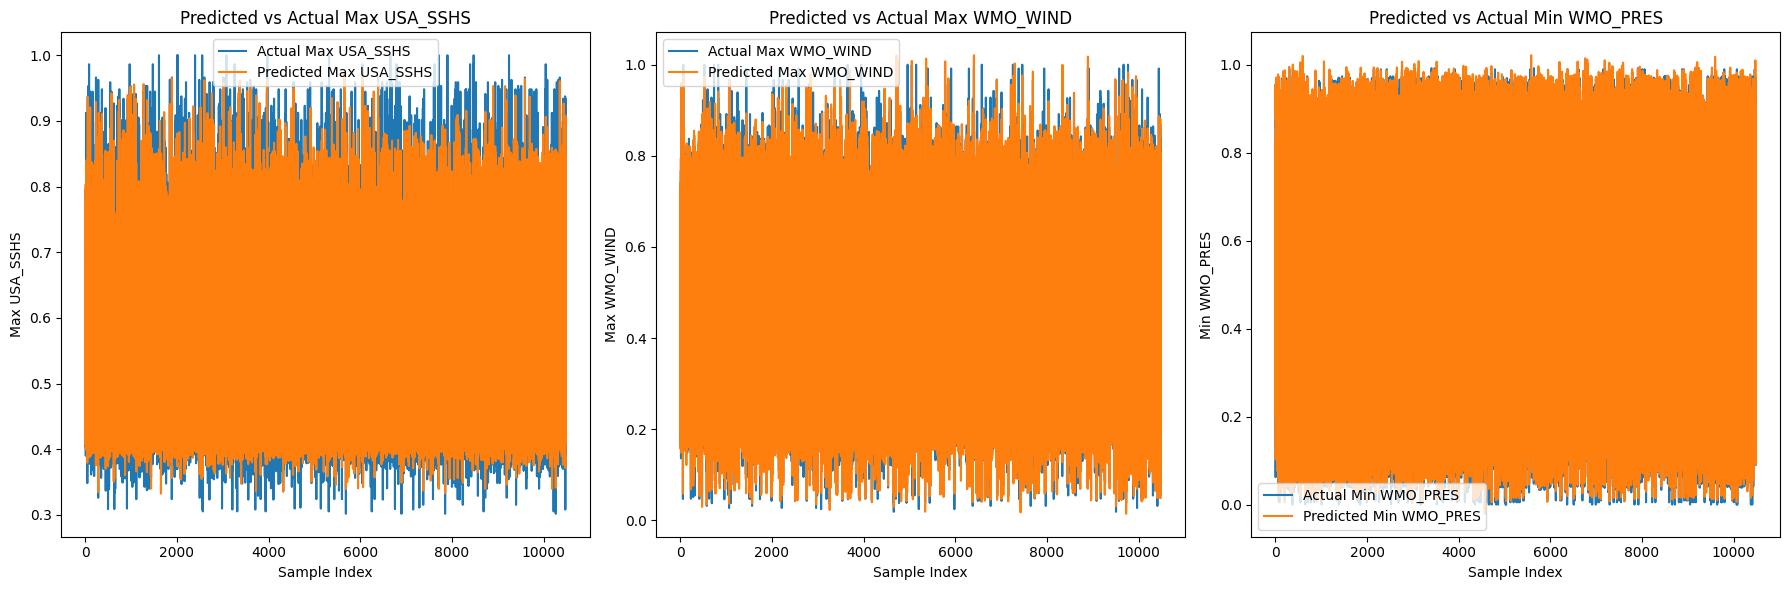

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

loss = model.evaluate([X_seq_test, X_static_test], y_test)
print(f"Test Loss (MSE from the model): {loss}")

y_pred = model.predict([X_seq_test, X_static_test])

targets = ['Max USA_SSHS', 'Max WMO_WIND', 'Min WMO_PRES']
metrics = {}

for i, target in enumerate(targets):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    metrics[target] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R²': r2}

for target, target_metrics in metrics.items():
    print(f"Metrics for {target}:")
    print(f"  Mean Absolute Error (MAE): {target_metrics['MAE']:.4f}")
    print(f"  Mean Squared Error (MSE): {target_metrics['MSE']:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {target_metrics['RMSE']:.4f}")
    print(f"  R-squared (R²): {target_metrics['R²']:.4f}")

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

for i, target in enumerate(targets):
    axs[i].plot(y_test[:, i], label=f'Actual {target}')
    axs[i].plot(y_pred[:, i], label=f'Predicted {target}')
    axs[i].set_title(f'Predicted vs Actual {target}')
    axs[i].set_xlabel('Sample Index')
    axs[i].set_ylabel(target)
    axs[i].legend()

plt.tight_layout() 

output_path = "../images/predicted_vs_actual_grid.png"
plt.savefig(output_path)

plt.show()

plt.close()

### Saving the model

In [38]:
import joblib

model.save("time_series_model.h5")
print("Model saved to hybrid_model.h5")

joblib.dump(scaler_seq, "scaler_seq.pkl")
joblib.dump(scaler_static, "scaler_static.pkl")
print("Scalers saved to scaler_seq.pkl and scaler_static.pkl")

Model saved to hybrid_model.h5
Scalers saved to scaler_seq.pkl and scaler_static.pkl
